# Industrial Sensor Anomaly Detection (SMAP & MSL)

### Objective & Approach
- End-to-end anomaly detection on multivariate time series from NASA SMAP/MSL.
- Train a **global LSTM Autoencoder** on all series, then **fine-tune per series**.
- Robust preprocessing (numeric coercion, variance filtering), synthetic timestamps if needed.
- Unified scoring & thresholding; export per-series artifacts and a run-level report.

## Data, Layout & Selection
- Download via **KaggleHub** → auto-detect `train/`, `test/`, and `labeled_anomalies.csv`.
- Series selection:
  - `CHOICE="ALL"` or mixed tokens (e.g., `A-1, A-3, 5-12` by name/index range).
  - `USE_LABELED_ONLY=True` to restrict evaluation to labeled series.
- Timestamps:
  - Use real timestamp column if present (`timestamp/datetime/...`).
  - Otherwise synthesize (`START_TIME_DEFAULT`, `FREQ_DEFAULT`); timestamps propagate to CSVs.

## Preprocessing, Enrichment & Windowing
- **Robust numeric cleaning**: numeric coercion, drop NaN/Inf rows, remove near-constant columns.
- **Cross-series alignment** to the **minimum feature count** (pad/truncate).
- **Feature enrichment** (optional): for each feature add **first-difference** and **rolling std** (`ROLL_WIN`) → `3×` features.
- **Scaling**: single `MinMaxScaler` fit on concatenated TRAIN of all series.
- **Windowing**: slide `(WINDOW, STRIDE)` to build `[batch, time, features]`.

## Model & Training
- **LSTM Autoencoder**  
  Encoder: `LSTM(64) → Dropout → LSTM(32) → Dense(latent)`  
  Decoder: `RepeatVector → LSTM(32) → Dropout → LSTM(64) → TimeDistributed(Dense)`
- Loss/Opt: `MSE` with `Adam(1e-3)`.
- Global training with `EarlyStopping` + `ReduceLROnPlateau`.
- **Per-series fine-tune**: clone global model, few epochs at lower LR on that series’ TRAIN.

## Scoring, Thresholding & Post-processing
- **Score per window**:
  - Top-k time-position error + top-k feature-wise error (on raw recon error),
  - Same on **first differences**, min–max normalized and **smoothed**.
- **Threshold**:
  - With labels:
    - `THRESHOLD_STRATEGY="best_f1"` → maximize F1 (high recall).
    - `"precision_floor"` → enforce `TARGET_PRECISION`, then maximize recall.
  - Without labels: high-quantile of TRAIN scores (`TRAIN_ALERT_Q`).
- **Morphology**:
  - Remove short islands (`MIN_EVENT_LEN`), merge nearby events (`MERGE_GAP`), optional dilation (`DILATE_NEIGHBOR`).

## Outputs
- **Per-series**:
  - Metrics: P/R/F1, ROC AUC, AUPRC (if positives exist).
  - Plots: ROC, PR, **Score vs Time** (+ threshold), **Reconstruction MSE vs Time**, **Score+MSE (twin axes)**.
  - CSVs:
    - `suspicious_<series>.csv` (merged anomaly intervals + timestamps + score stats)
    - `suspicious_points_<series>.csv` (per-window decisions + timestamps)
    - `recon_timeseries_<series>.csv` (per-window MSE/score/prediction + point indices + timestamps)
- **Run-level**:
  - `batch_summary.csv` (per-series metrics table)
  - `ALL_EVENTS.csv` (unified anomaly intervals across series)
  - `FINAL_REPORT.md` (medians, counts, top/bottom by F1, figure paths)

## Practical Tuning
- Want **higher precision** (fewer false alarms)?
  - Use `"precision_floor"`, raise `TARGET_PRECISION` (e.g., 0.30–0.50),
  - Increase `MIN_EVENT_LEN`, reduce `MERGE_GAP`, disable `DILATE_NEIGHBOR`,
  - Increase `WINDOW` (smoother context).
- Want **higher recall** (fewer misses)?
  - Use `"best_f1"`, relax morphology (smaller `MIN_EVENT_LEN`, allow dilation),
  - Lower strictness by reducing precision floor or smoothing less.

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
TensorFlow: 2.19.0
Mounted at /content/drive
Saving outputs to: /content/drive/MyDrive/anomaly_task2_outputs/run_20251015_181115
Using Colab cache for faster access to the 'nasa-anomaly-detection-dataset-smap-msl' dataset.

Path to dataset files: /kaggle/input/nasa-anomaly-detection-dataset-smap-msl
Dataset prepared under: /content/data_smap_msl
total 16K
drwxr-xr-x 3 root root 4.0K Oct 15 18:11 .
drwxr-xr-x 1 root root 4.0K Oct 15 18:11 ..
drwxr-sr-x 3 root root 4.0K Oct 12 06:03 data
-rw-r--r-- 1 root root 3.9K Oct 12 06:03 labeled_anomalies.csv
train_dir: /content/data_smap_msl/data/data/train
test_dir : /content/data_smap_msl/data/data/test
labels   : /content/data_smap_msl/labeled_anomalies.csv
Found series: 82
['A-1', 'A-2', 'A-3', 'A-4', 'A-5', 'A-6', 'A-7', 'A-8', 'A-9', 'B-1']
Total series: 82 | Filtered: 82
Selected: 82 | First: A-1
SAVE_DIR: /content/drive/MyDrive/anomaly_task2_outputs/run_20251015_181115/series_A-1


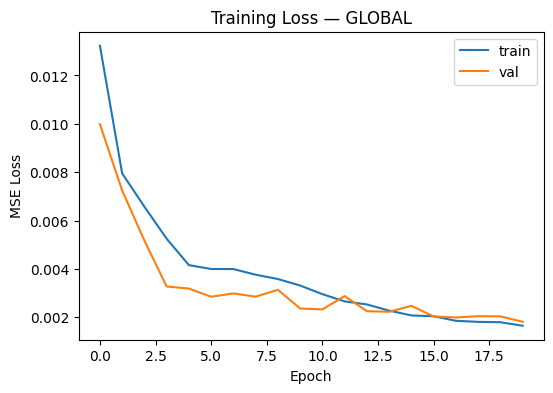


— Evaluating: A-1
[A-1] P=0.017 R=1.000 F1=0.033 AUC=0.495

— Evaluating: A-2
[A-2] P=0.099 R=0.341 F1=0.153 AUC=0.729

— Evaluating: A-3
[A-3] P=0.032 R=0.698 F1=0.061 AUC=0.437

— Evaluating: A-4
[A-4] P=0.035 R=0.388 F1=0.065 AUC=0.578

— Evaluating: A-5
[A-5] P=0.040 R=1.000 F1=0.076 AUC=0.675

— Evaluating: A-6
[A-6] P=0.029 R=1.000 F1=0.056 AUC=0.307

— Evaluating: A-7
[A-7] P=0.410 R=0.998 F1=0.581 AUC=0.611

— Evaluating: A-8
[A-8] P=0.491 R=0.998 F1=0.658 AUC=0.448

— Evaluating: A-9
[A-9] P=0.813 R=0.857 F1=0.834 AUC=0.915

— Evaluating: B-1
[B-1] P=0.025 R=1.000 F1=0.050 AUC=0.677

— Evaluating: C-1
[C-1] P=0.027 R=0.981 F1=0.053 AUC=0.184

— Evaluating: C-2
[C-2] P=0.048 R=1.000 F1=0.091 AUC=0.133

— Evaluating: D-1
[D-1] P=0.393 R=1.000 F1=0.564 AUC=0.165

— Evaluating: D-11
[D-11] P=0.065 R=1.000 F1=0.123 AUC=0.767

— Evaluating: D-14
[D-14] P=nan R=nan F1=nan AUC=nan

— Evaluating: D-15
[D-15] P=0.034 R=1.000 F1=0.067 AUC=0.331

— Evaluating: D-16
[D-16] P=nan R=nan F1=

,series,precision,recall,f1,roc_auc,auprc
8,A-9,0.812515,0.857034,0.834181,0.914624,0.895526
22,D-7,0.538613,0.992756,0.698344,0.755099,0.548739
17,D-2,0.501054,1.000000,0.667603,0.711469,0.645380
18,D-3,0.494510,0.999400,0.661638,0.407190,0.315892
19,D-4,0.493729,1.000000,0.661069,0.413263,0.338450
7,A-8,0.490715,0.998189,0.657969,0.447874,0.424154
6,A-7,0.409546,0.997561,0.580691,0.611187,0.306662
39,F-2,0.400691,1.000000,0.572133,0.585040,0.370465
31,E-3,0.396702,1.000000,0.568056,0.356636,0.304185
12,D-1,0.392663,1.000000,0.563902,0.164804,0.274923



Bottom-10 by F1:


,series,precision,recall,f1,roc_auc,auprc
46,G-2,0.013701,1.000000,0.027031,0.493405,0.013706
47,G-3,0.014016,1.000000,0.027645,0.487723,0.014016
23,D-8,0.014079,1.000000,0.027767,0.494225,0.014086
0,A-1,0.016797,1.000000,0.033039,0.495022,0.016803
75,T-3,0.018804,1.000000,0.036913,0.385516,0.013859
52,M-2,0.019413,1.000000,0.038087,0.032269,0.010206
67,R-1,0.019485,1.000000,0.038225,0.493258,0.019485
38,F-1,0.021059,0.437500,0.040184,0.401707,0.014784
40,F-3,0.021030,1.000000,0.041195,0.448854,0.010895
21,D-6,0.024546,0.357143,0.045935,0.434776,0.016117


In [1]:
# ============================================
# Industrial Sensor Anomaly Detection (SMAP & MSL)
# Global AE + per-series fine-tune + robust eval
# + Synthetic Timestamps + threshold switch + Unified Events CSV
# + Reconstruction error/score timeseries (CSV+PNGs) per series
# ============================================

# -----------------------------
# 0) Imports
# -----------------------------
import os, sys, glob, shutil, zipfile, json, time, re, ast
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    precision_recall_fscore_support, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

print("Python:", sys.version)
print("TensorFlow:", tf.__version__)

# -----------------------------
# 1) Mount Drive (outputs)
# -----------------------------
from google.colab import drive
drive.mount('/content/drive')

PROJECT_ROOT = "/content/drive/MyDrive/anomaly_task2_outputs"
os.makedirs(PROJECT_ROOT, exist_ok=True)
RUN_STAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
OUT_DIR = os.path.join(PROJECT_ROOT, f"run_{RUN_STAMP}")
os.makedirs(OUT_DIR, exist_ok=True)
print("Saving outputs to:", OUT_DIR)

# -----------------------------
# 2) Data (KaggleHub)
# -----------------------------
import kagglehub

DATA_ROOT = "/content/data_smap_msl"
os.makedirs(DATA_ROOT, exist_ok=True)

def download_with_kagglehub():
    try:
        print("Downloading with KaggleHub...")
        path = kagglehub.dataset_download("patrickfleith/nasa-anomaly-detection-dataset-smap-msl")
        print("\nPath to dataset files:", path)
        # copy to DATA_ROOT
        if os.path.isdir(path):
            for item in os.listdir(path):
                src = os.path.join(path, item)
                dst = os.path.join(DATA_ROOT, item)
                if os.path.isdir(src):
                    if not os.path.exists(dst):
                        shutil.copytree(src, dst)
                else:
                    shutil.copy2(src, dst)
        # unzip any zips if present
        for z in glob.glob(os.path.join(DATA_ROOT, "*.zip")):
            print("Extracting:", z)
            with zipfile.ZipFile(z, 'r') as zz:
                zz.extractall(DATA_ROOT)
            os.remove(z)
        return True
    except Exception as e:
        print("KaggleHub download failed:", repr(e))
        return False

ok = download_with_kagglehub()
assert ok, "No dataset could be downloaded."
print("Dataset prepared under:", DATA_ROOT)
!ls -lah $DATA_ROOT

# -----------------------------
# 3) Resolve layout & series list
# -----------------------------
def resolve_dataset_paths(data_root: str):
    train_dirs = [p for p in glob.glob(os.path.join(data_root, "**", "train"), recursive=True) if os.path.isdir(p)]
    test_dirs  = [p for p in glob.glob(os.path.join(data_root, "**", "test" ), recursive=True) if os.path.isdir(p)]
    label_hits = glob.glob(os.path.join(data_root, "**", "labeled_anomalies.csv"), recursive=True)
    if not train_dirs or not test_dirs:
        raise RuntimeError("train/ or test/ folder not found recursively.")
    candidates = []
    for tdir in sorted(set(train_dirs)):
        parent = os.path.dirname(tdir)
        sibl_test = os.path.join(parent, "test")
        if sibl_test in test_dirs:
            n_train = len([f for f in glob.glob(os.path.join(tdir, "*")) if os.path.isfile(f)])
            n_test  = len([f for f in glob.glob(os.path.join(sibl_test, "*")) if os.path.isfile(f)])
            candidates.append((n_train + n_test, tdir, sibl_test))
    if candidates:
        _, train_dir, test_dir = max(candidates, key=lambda x: x[0])
    else:
        def count_files(d): return len([f for f in glob.glob(os.path.join(d, "*")) if os.path.isfile(f)])
        train_dir = max(train_dirs, key=count_files)
        test_dir  = max(test_dirs,  key=count_files)
    labels_csv = label_hits[0] if label_hits else None
    return train_dir, test_dir, labels_csv

train_dir, test_dir, labels_csv = resolve_dataset_paths(DATA_ROOT)
print("train_dir:", train_dir)
print("test_dir :", test_dir)
print("labels   :", labels_csv)

def list_series_from_dir(d: str):
    files = [f for f in glob.glob(os.path.join(d, "*")) if os.path.isfile(f)]
    stems = sorted(list({os.path.splitext(os.path.basename(f))[0] for f in files}))
    return stems

SERIES = list_series_from_dir(train_dir)
print("Found series:", len(SERIES))
print(SERIES[:10])

# -----------------------------
# 4) Choose Series (supports single series too)
# -----------------------------
CHOICE = "ALL"
USE_LABELED_ONLY = False

def _normalize_id(s: str) -> str:
    s = str(s).strip()
    s = os.path.splitext(os.path.basename(s))[0]
    return s.replace(" ", "").replace("_", "-")

def _indices_from_token(tok: str, n: int):
    tok = tok.strip()
    if re.fullmatch(r"\d+-\d+", tok):
        a, b = map(int, tok.split("-"))
        if 1 <= a <= n and 1 <= b <= n: a, b = a-1, b-1
        if a > b: a, b = b, a
        return [i for i in range(max(0,a), min(n-1,b)+1)]
    if tok.isdigit():
        i = int(tok)
        if 0 <= i < n: return [i]
        if 1 <= i <= n: return [i-1]
        return []
    return []

series_pool = SERIES[:]
if USE_LABELED_ONLY and labels_csv and os.path.exists(labels_csv):
    lab = pd.read_csv(labels_csv)
    id_col = next((c for c in ["chan_id","series","file","name","id","channel","series_id"] if c in lab.columns), lab.columns[0])
    labeled = set(lab[id_col].astype(str).map(_normalize_id))
    series_pool = [s for s in SERIES if _normalize_id(s) in labeled]

N = len(series_pool); assert N>0, "No series available."
choice = CHOICE.strip()
selected = []
if choice.upper()=="ALL":
    selected = series_pool[:]
else:
    tokens = [t for t in re.split(r"[,\s]+", choice) if t]
    norm_map = {_normalize_id(s): s for s in series_pool}
    for tok in tokens:
        nname = _normalize_id(tok)
        if nname in norm_map and norm_map[nname] not in selected:
            selected.append(norm_map[nname]); continue
        idxs = _indices_from_token(tok, N)
        for i in idxs:
            s = series_pool[i]
            if s not in selected: selected.append(s)

if not selected: selected = [series_pool[0]]
RUN_ALL = len(selected) > 1
SERIES_TO_RUN = selected[:]
SELECT_SERIES = selected[0]

print(f"Total series: {len(SERIES)} | Filtered: {len(series_pool)}")
print(f"Selected: {len(SERIES_TO_RUN)} | First: {SELECT_SERIES}")
SAVE_DIR = os.path.join(OUT_DIR, f"series_{SELECT_SERIES}")
os.makedirs(SAVE_DIR, exist_ok=True)
print("SAVE_DIR:", SAVE_DIR)

# -----------------------------
# 5) IO + Timestamp helpers
# -----------------------------
def _first_existing_with_stem(dir_path: str, stem: str):
    for ext in [".csv", ".txt", ".npy", ".npz"]:
        fp = os.path.join(dir_path, stem + ext)
        if os.path.exists(fp): return fp
    hits = glob.glob(os.path.join(dir_path, stem + ".*"))
    if not hits: raise FileNotFoundError(f"No file found for series '{stem}' in {dir_path}")
    return hits[0]

def _load_any(fp: str) -> pd.DataFrame:
    ext = os.path.splitext(fp)[1].lower()
    if ext == ".csv": return pd.read_csv(fp)
    if ext == ".txt":
        try: return pd.read_csv(fp)
        except: return pd.read_csv(fp, delim_whitespace=True, header=None)
    if ext == ".npy":
        arr = np.load(fp);
        if arr.ndim == 1: arr = arr[:, None]
        return pd.DataFrame(arr, columns=[f"f{i}" for i in range(arr.shape[1])])
    if ext == ".npz":
        npz = np.load(fp); key = next(iter(npz.keys()))
        arr = npz[key]
        if arr.ndim == 1: arr = arr[:, None]
        return pd.DataFrame(arr, columns=[f"f{i}" for i in range(arr.shape[1])])
    return pd.read_csv(fp)

# --- Synthetic time settings (reporting layer only) ---
USE_SYNTHETIC_TIME  = True
START_TIME_DEFAULT  = "2020-01-01 00:00:00"
FREQ_DEFAULT        = "1s"     # '1s' , '5s', '1min', '10ms', ...
TIME_TZ             = None

_TS_CANDIDATES = {"timestamp","time","datetime","date"}

def _extract_time_column(df: pd.DataFrame):
    for c in df.columns:
        if str(c).strip().lower() in _TS_CANDIDATES:
            ts = pd.to_datetime(df[c], errors="coerce")
            if ts.notna().sum() >= max(5, int(0.8*len(df))):
                return ts.reset_index(drop=True)
    return None

def _make_synth_time(n: int, start: str, freq: str, tz=None) -> pd.Series:
    idx = pd.date_range(start=start, periods=int(n), freq=freq)
    if tz:
        try:
            idx = idx.tz_localize(tz)
        except Exception:
            pass
    return pd.Series(idx, name="timestamp")

# -----------------------------
# 6) Preprocess helpers + Enrichment
# -----------------------------
def robust_numeric_df_with_index(df: pd.DataFrame, min_non_na: int = 5):
    if df is None or df.shape[1] == 0:
        return pd.DataFrame(), pd.Index([])
    cols = []
    tmp = {}
    for c in df.columns:
        s = pd.to_numeric(df[c], errors="coerce")
        if s.notna().sum() >= min_non_na:
            tmp[c] = s.astype("float32")
            cols.append(c)
    if not cols:
        return pd.DataFrame(), pd.Index([])
    num = pd.DataFrame(tmp)
    num = num.loc[:, ~num.columns.duplicated()]
    num = num.replace([np.inf, -np.inf], np.nan)
    keep_row_mask = num.notna().all(axis=1)
    num = num.loc[keep_row_mask].copy()
    if len(num) > 0:
        var = num.var(axis=0, skipna=True)
        num = num.loc[:, var > 1e-12]
    kept_idx = df.index[keep_row_mask]
    return num.reset_index(drop=True), kept_idx

def has_numeric(df: pd.DataFrame) -> bool:
    return (df is not None) and (df.shape[1] > 0)

def drop_low_variance(df, thresh=1e-8):
    var = df.var(axis=0, skipna=True)
    keep = var[var > thresh].index
    return df[keep]

def make_windows(arr, window, stride):
    L, F = arr.shape
    idxs = []
    for s in range(0, L - window + 1, stride):
        idxs.append((s, s+window))
    X = np.stack([arr[s:e] for s,e in idxs], axis=0) if idxs else np.zeros((0, window, F), dtype=arr.dtype)
    return X, np.array(idxs)

def _rolling_std_1d(x, win=30):
    out = np.zeros_like(x, dtype=np.float32)
    w = int(max(2, win))
    cumsum = np.cumsum(x, dtype=float)
    cumsum2 = np.cumsum(x*x, dtype=float)
    for i in range(len(x)):
        s = max(0, i-w+1); n = i - s + 1
        sumx  = cumsum[i]  - (cumsum[s-1]  if s>0 else 0.0)
        sumx2 = cumsum2[i] - (cumsum2[s-1] if s>0 else 0.0)
        mean = sumx/n
        var  = max(0.0, (sumx2/n) - mean*mean)
        out[i] = np.sqrt(var)
    return out

def enrich_features(mat, win=30):
    L, F = mat.shape
    diffs = np.zeros_like(mat, dtype=np.float32)
    rstd  = np.zeros_like(mat, dtype=np.float32)
    diffs[:, :] = np.vstack([np.zeros((1, F), dtype=np.float32), np.diff(mat, axis=0)]).astype(np.float32)
    for j in range(F):
        rstd[:, j] = _rolling_std_1d(mat[:, j].astype(np.float32), win=win)
    return np.concatenate([mat.astype(np.float32), diffs, rstd], axis=1)

# -----------------------------
# 7) LSTM Autoencoder
# -----------------------------
def build_lstm_ae(timesteps: int, features: int, latent: int = 8) -> tf.keras.Model:
    inp = layers.Input(shape=(timesteps, features))
    x = layers.LSTM(64, return_sequences=True)(inp)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(32, return_sequences=False)(x)
    z = layers.Dense(latent, activation="linear", name="bottleneck")(x)
    x = layers.RepeatVector(timesteps)(z)
    x = layers.LSTM(32, return_sequences=True)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(64, return_sequences=True)(x)
    out = layers.TimeDistributed(layers.Dense(features))(x)
    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
    return model

# -----------------------------
# 8) Scoring helpers
# -----------------------------
def smooth(x, k=7):
    if k <= 1: return x
    w = np.ones(k)/k
    return np.convolve(x, w, mode='same')

def topk_time_score(X, Xhat, topk_ratio=0.2):
    err = (X - Xhat)**2
    per_t = err.mean(axis=2)
    k = max(1, int(per_t.shape[1] * topk_ratio))
    topk = np.partition(per_t, -k, axis=1)[:, -k:]
    return topk.mean(axis=1)

def topk_feat_score(X, Xhat, feat_top_ratio=0.3):
    err = (X - Xhat)**2
    per_f = err.mean(axis=1)
    kf = max(1, int(per_f.shape[1] * feat_top_ratio))
    topf = np.partition(per_f, -kf, axis=1)[:, -kf:]
    return topf.mean(axis=1)

def safe_minmax(a):
    a = np.asarray(a)
    rng = np.ptp(a)
    if rng == 0: return np.zeros_like(a)
    return (a - np.min(a)) / (rng + 1e-12)

def build_scores(X, Xhat):
    # base
    ts = safe_minmax(topk_time_score(X, Xhat, topk_ratio=0.2))
    fs = safe_minmax(topk_feat_score(X, Xhat, feat_top_ratio=0.3))
    base = 0.7*ts + 0.3*fs
    # first-order differences
    Xd    = np.diff(X,    axis=1, prepend=X[:, :1, :])
    Xhatd = np.diff(Xhat, axis=1, prepend=Xhat[:, :1, :])
    ts_d = safe_minmax(topk_time_score(Xd, Xhatd, topk_ratio=0.2))
    fs_d = safe_minmax(topk_feat_score(Xd, Xhatd, feat_top_ratio=0.3))
    diff = 0.7*ts_d + 0.3*fs_d
    combo = 0.5*base + 0.5*diff
    return smooth(combo, k=7)

# -----------------------------
# 9) Settings (Global + FT + Threshold switch)
# -----------------------------
GLOBAL_MODE = True   # an global model

# Hyperparams
WINDOW = 60
STRIDE = 1
LATENT = 8
EPOCHS = 20
BATCH  = 256

# Threshold policy when labels exist
# "precision_floor"  or  "best_f1"
THRESHOLD_STRATEGY = "best_f1"

TARGET_PRECISION = 0.20
TRAIN_ALERT_Q   = 0.999
MIN_EVENT_LEN   = 3
MERGE_GAP       = 2
DILATE_NEIGHBOR = True
EXCLUDE_NAN_IN_SUMMARY = True

# Feature enrichment
ENRICH_FEATURES = True
ROLL_WIN = 30

# -----------------------------
# 10) Train Global + Evaluate  (includes recon plots/CSV)
# -----------------------------
if GLOBAL_MODE:
    assert len(SERIES_TO_RUN) > 0

    # Load & clean, while preserving kept row indices (for timestamp alignment)
    per_series, feat_counts, skipped = [], [], []
    time_columns_train, time_columns_test = {}, {}
    for sname in SERIES_TO_RUN:
        try:
            train_fp = _first_existing_with_stem(train_dir, sname)
            test_fp  = _first_existing_with_stem(test_dir,  sname)
            tdf_raw = _load_any(train_fp)
            vdf_raw = _load_any(test_fp)

            # capture time columns if exist
            t_time = _extract_time_column(tdf_raw)
            v_time = _extract_time_column(vdf_raw)

            tdf_num, t_kept = robust_numeric_df_with_index(tdf_raw, min_non_na=5)
            vdf_num, v_kept = robust_numeric_df_with_index(vdf_raw, min_non_na=5)

            if not has_numeric(tdf_num) or not has_numeric(vdf_num):
                print(f"[SKIP] {sname}: no numeric columns"); skipped.append(sname); continue

            tdf_num = drop_low_variance(tdf_num, thresh=1e-8)
            if not has_numeric(tdf_num):
                print(f"[SKIP] {sname}: dropped by low variance"); skipped.append(sname); continue

            # timestamps for cleaned frames
            if t_time is None and USE_SYNTHETIC_TIME:
                t_time = _make_synth_time(len(tdf_raw), START_TIME_DEFAULT, FREQ_DEFAULT, TIME_TZ)
            if v_time is None and USE_SYNTHETIC_TIME:
                v_time = _make_synth_time(len(vdf_raw), START_TIME_DEFAULT, FREQ_DEFAULT, TIME_TZ)
            if isinstance(t_time, pd.Series) and len(t_time)==len(tdf_raw):
                t_time = t_time.iloc[t_kept].reset_index(drop=True)
            else:
                t_time = _make_synth_time(len(tdf_num), START_TIME_DEFAULT, FREQ_DEFAULT, TIME_TZ)
            if isinstance(v_time, pd.Series) and len(v_time)==len(vdf_raw):
                v_time = v_time.iloc[v_kept].reset_index(drop=True)
            else:
                v_time = _make_synth_time(len(vdf_num), START_TIME_DEFAULT, FREQ_DEFAULT, TIME_TZ)

            time_columns_train[sname] = t_time
            time_columns_test[sname]  = v_time

            per_series.append((sname, tdf_num, vdf_num))
            feat_counts.append(tdf_num.shape[1])

        except Exception as e:
            print(f"[SKIP] {sname}: {e}"); skipped.append(sname)

    print(f"Loaded {len(per_series)} series; skipped {len(skipped)}: {skipped}")
    assert len(per_series) > 0, "No usable series."

    # Positional alignment to min feature count
    n_feats = int(min(feat_counts)); assert n_feats>0
    align_cfg = {"n_feats": n_feats}

    def apply_alignment_np(df_num: pd.DataFrame, align: dict) -> np.ndarray:
        arr = df_num.astype(np.float32).values
        if arr.shape[1] < align["n_feats"]:
            pad = np.zeros((arr.shape[0], align["n_feats"] - arr.shape[1]), dtype=np.float32)
            arr = np.hstack([arr, pad])
        return arr[:, :align["n_feats"]]

    # Aligned & enriched arrays (TRAIN only for scaler & global training)
    aligned_train = []
    for _, tdf, _ in per_series:
        arr = apply_alignment_np(tdf, align_cfg)
        if ENRICH_FEATURES:
            arr = enrich_features(arr, win=ROLL_WIN)  # [L, 3*n_feats]
        aligned_train.append(arr)
    aligned_feat_dim = aligned_train[0].shape[1]
    assert all(a.shape[1]==aligned_feat_dim for a in aligned_train), "Inconsistent enriched dims."

    # One scaler on concatenated TRAIN
    scaler = MinMaxScaler()
    all_train_mat = np.concatenate(aligned_train, axis=0)
    scaler.fit(all_train_mat)

    # GLOBAL training windows
    X_train_all = []
    for arr in aligned_train:
        Xw, _ = make_windows(scaler.transform(arr), WINDOW, STRIDE)
        if Xw.shape[0] > 0: X_train_all.append(Xw)
    assert len(X_train_all)>0, "No windows; tune WINDOW/STRIDE."
    X_train_all = np.concatenate(X_train_all, axis=0)
    print("Global train windows:", X_train_all.shape)

    # Build & train global model
    timesteps, features = X_train_all.shape[1], X_train_all.shape[2]
    model = build_lstm_ae(timesteps, features, latent=LATENT)
    es  = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5)
    hist = model.fit(X_train_all, X_train_all, validation_split=0.2, epochs=EPOCHS,
                     batch_size=BATCH, shuffle=False, callbacks=[es, rlr], verbose=1)

    GLOBAL_MODEL_PATH = os.path.join(OUT_DIR, "global_lstm_autoencoder.keras")
    model.save(GLOBAL_MODEL_PATH)
    print("Global model saved:", GLOBAL_MODEL_PATH)

    # Save global training loss plot
    plt.figure(figsize=(6,4))
    plt.plot(hist.history["loss"], label="train")
    if "val_loss" in hist.history: plt.plot(hist.history["val_loss"], label="val")
    plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.title("Training Loss — GLOBAL"); plt.legend()
    plt.savefig(os.path.join(OUT_DIR, "training_loss_GLOBAL.png"), bbox_inches="tight", dpi=160)
    plt.show()

    # ----- Evaluate per series (FT + thresholds + outputs)
    results = []
    all_events_rows = []   # unified CSV collector

    for sname, tdf_num, vdf_num in per_series:
        print("\n— Evaluating:", sname)
        S_DIR = os.path.join(OUT_DIR, f"series_{sname}"); os.makedirs(S_DIR, exist_ok=True)

        # Labels → test window labels
        def parse_labels_for_series(series_name: str, labels_csv_path: str, train_len: int, test_len: int):
            labels_df = pd.DataFrame(columns=["start","end"])
            if labels_csv_path and os.path.exists(labels_csv_path):
                lab = pd.read_csv(labels_csv_path)
                id_col = next((c for c in ["chan_id","series","file","name","id","channel","series_id"] if c in lab.columns), lab.columns[0])
                def _norm(s: str) -> str:
                    s = str(s).strip()
                    s = os.path.splitext(os.path.basename(s))[0]
                    return s.replace(" ", "").replace("_","-")
                m = lab[id_col].astype(str).map(_norm) == _norm(series_name)
                if m.any():
                    row = lab.loc[m].iloc[0]
                    seqs = []
                    if "anomaly_sequences" in lab.columns:
                        cell = row["anomaly_sequences"]
                        if pd.notna(cell) and str(cell).strip() != "":
                            try:
                                obj = json.loads(str(cell))
                            except Exception:
                                obj = ast.literal_eval(str(cell).replace(";", ","))
                            if isinstance(obj, dict) and "start" in obj and "end" in obj:
                                seqs = [(int(obj["start"]), int(obj["end"]))]
                            elif isinstance(obj, (list, tuple)):
                                for it in obj:
                                    if isinstance(it, dict) and "start" in it and "end" in it:
                                        seqs.append((int(it["start"]), int(it["end"])))
                                    elif isinstance(it, (list, tuple)) and len(it)>=2:
                                        seqs.append((int(it[0]), int(it[1])))
                    labels_df = pd.DataFrame(seqs, columns=["start","end"]) if seqs else pd.DataFrame(columns=["start","end"])
            if len(labels_df)>0:
                df = labels_df.copy()
                df["start"] = df["start"] - len(tdf_num)
                df["end"]   = df["end"]   - len(tdf_num)
                df = df[df["end"] >= 0]
                df["start"] = df["start"].clip(lower=0)
                df["end"]   = df["end"].clip(upper=len(vdf_num)-1)
                df = df[df["start"] <= df["end"]].reset_index(drop=True)
                labels_df = df
            return labels_df

        labels_df = parse_labels_for_series(sname, labels_csv, len(tdf_num), len(vdf_num))

        # Transform & windows (+ enrichment)
        def apply_alignment_np2(df_num, align):
            arr = df_num.astype(np.float32).values
            if arr.shape[1] < align["n_feats"]:
                pad = np.zeros((arr.shape[0], align["n_feats"] - arr.shape[1]), dtype=np.float32)
                arr = np.hstack([arr, pad])
            return arr[:, :align["n_feats"]]

        train_raw = apply_alignment_np2(tdf_num, align_cfg)
        test_raw  = apply_alignment_np2(vdf_num, align_cfg)
        if ENRICH_FEATURES:
            train_raw = enrich_features(train_raw, win=ROLL_WIN)
            test_raw  = enrich_features(test_raw,  win=ROLL_WIN)

        train_np = scaler.transform(train_raw)
        test_np  = scaler.transform(test_raw)
        X_train, train_idxs = make_windows(train_np, WINDOW, STRIDE)
        X_test,  test_idxs  = make_windows(test_np,  WINDOW, STRIDE)
        if X_test.shape[0]==0:
            print(f"[SKIP] {sname}: no test windows"); continue

        # Build test time index (aligned to cleaned test length)
        time_test_series = time_columns_test[sname]
        if len(time_test_series) != len(test_np):
            time_test_series = _make_synth_time(len(test_np), START_TIME_DEFAULT, FREQ_DEFAULT, TIME_TZ)

        # Point → window labels
        y_test_point = np.zeros(len(test_np), dtype=np.int32)
        for _, r in labels_df.iterrows():
            s = max(0, int(r.start)); e = min(len(test_np)-1, int(r.end))
            if s<=e: y_test_point[s:e+1] = 1
        y_test_win = np.zeros(len(test_idxs), dtype=np.int32)
        for i,(s,e) in enumerate(test_idxs):
            if y_test_point[s:e].sum()>0: y_test_win[i]=1
        has_pos = y_test_win.sum()>0

        # Fine-Tune per-series
        fine_model = tf.keras.models.clone_model(model)
        fine_model.set_weights(model.get_weights())
        fine_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="mse")
        es_ft = callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
        if X_train.shape[0] > 0:
            fine_model.fit(X_train, X_train, validation_split=0.2, epochs=5, batch_size=64,
                           shuffle=False, verbose=0, callbacks=[es_ft])

        # Reconstructions + scores
        test_recon  = fine_model.predict(X_test,  verbose=0)
        train_recon = fine_model.predict(X_train, verbose=0) if X_train.shape[0]>0 else None
        y_scores_s = build_scores(X_test, test_recon)

        # ---- Threshold selection (switch)
        if has_pos:
            prec, rec, thr = precision_recall_curve(y_test_win, y_scores_s)
            f1 = (2*prec*rec)/(prec+rec+1e-12)
            if len(f1)>0 and len(thr)>0:
                j = int(np.nanargmax(f1))
                bestF1_thr = float(thr[max(j-1, 0)])
                if THRESHOLD_STRATEGY.lower() == "best_f1":
                    THRESHOLD = bestF1_thr
                else:  # precision_floor
                    idxs = np.where(prec >= TARGET_PRECISION)[0]
                    if len(idxs)>0:
                        jj = idxs[np.argmax(rec[idxs])]
                        THRESHOLD = float(thr[max(jj-1,0)])
                    else:
                        THRESHOLD = bestF1_thr
            else:
                THRESHOLD = float(np.median(y_scores_s))
        else:
            if train_recon is not None and X_train.shape[0]>0:
                train_scores = build_scores(X_train, train_recon)
                THRESHOLD = float(np.quantile(train_scores, TRAIN_ALERT_Q))
            else:
                THRESHOLD = float(np.quantile(y_scores_s, TRAIN_ALERT_Q))

        # ---- Binary + post-proc
        y_pred = (y_scores_s >= THRESHOLD).astype(int)

        # remove short islands
        pred = y_pred.copy()
        runs = np.where(np.diff(np.r_[0, pred, 0]) != 0)[0].reshape(-1,2)  # [start,end)
        for ss, ee in runs:
            if (ee - ss) < max(2, MIN_EVENT_LEN):
                pred[ss:ee] = 0

        # merge close events
        pred_idx = np.where(pred == 1)[0]
        intervals = []
        if pred_idx.size > 0:
            st = pv = pred_idx[0]
            for i in pred_idx[1:]:
                if i - pv <= MERGE_GAP:
                    pv = i
                else:
                    intervals.append((st, pv)); st = pv = i
            intervals.append((st, pv))

        pred[:] = 0
        for s,e in intervals:
            pred[s:e+1] = 1

        if DILATE_NEIGHBOR and pred.sum()>0:
            ones = np.where(pred==1)[0]
            pred[np.clip(ones-1, 0, len(pred)-1)] = 1
            pred[np.clip(ones+1, 0, len(pred)-1)] = 1

        y_pred = pred

        # ---- Metrics
        if has_pos:
            prec_s, rec_s, f1_s, _ = precision_recall_fscore_support(y_test_win, y_pred, average="binary", zero_division=0)
            fpr, tpr, _ = roc_curve(y_test_win, y_scores_s); roc_auc = auc(fpr, tpr)
            auprc = average_precision_score(y_test_win, y_scores_s)
        else:
            prec_s = rec_s = f1_s = roc_auc = auprc = np.nan
            fpr = tpr = None

        print(f"[{sname}] P={prec_s:.3f} R={rec_s:.3f} F1={f1_s:.3f} AUC={roc_auc if not np.isnan(roc_auc) else float('nan'):.3f}")

        # ---- Save metrics JSON
        def _nan2none(x):
            return None if (isinstance(x,float) and (np.isnan(x) or np.isinf(x))) else (float(x) if isinstance(x,(np.floating,np.float32,np.float64)) else x)
        metrics_path = os.path.join(S_DIR, f"metrics_{sname}.json")
        with open(metrics_path, "w") as f:
            json.dump({
                "precision": _nan2none(prec_s), "recall": _nan2none(rec_s), "f1": _nan2none(f1_s),
                "roc_auc": _nan2none(roc_auc), "auprc": _nan2none(auprc),
                "threshold": float(THRESHOLD),
                "window": int(WINDOW), "stride": int(STRIDE),
                "topk_time": 0.2, "topk_feat": 0.3, "alpha": 0.7,
                "global_model": True, "fine_tuned": True, "has_positive": bool(has_pos),
                "enriched_features": bool(ENRICH_FEATURES), "roll_win": int(ROLL_WIN),
                "threshold_strategy": THRESHOLD_STRATEGY
            }, f, indent=2)

        # ---- ROC/PR plots
        if has_pos and fpr is not None:
            plt.figure(figsize=(6,5))
            plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
            plt.plot([0,1],[0,1],'--')
            plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC — {sname}"); plt.legend()
            plt.savefig(os.path.join(S_DIR, f"roc_{sname}.png"), bbox_inches="tight", dpi=160)
            plt.close()

            prec_p, rec_p, thr_p = precision_recall_curve(y_test_win, y_scores_s)
            plt.figure(figsize=(6,5))
            plt.plot(rec_p, prec_p)
            plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR Curve — {sname}")
            plt.savefig(os.path.join(S_DIR, f"pr_curve_{sname}.png"), bbox_inches="tight", dpi=160)
            plt.close()

        # ---- Score plot vs time
        plt.figure(figsize=(12,4))
        plt.plot(y_scores_s, label="Anomaly score (smoothed)")
        plt.axhline(THRESHOLD, linestyle="--", label="Threshold")
        plt.title(f"Anomaly Score vs. Time — {sname}")
        plt.xlabel(f"Window # (stride={STRIDE})"); plt.ylabel("Score"); plt.legend()
        plt.savefig(os.path.join(S_DIR, f"score_timeseries_{sname}.png"), bbox_inches="tight", dpi=160)
        plt.close()

        # ---- Reconstruction error timeseries + CSV + combined plot
        recon_mse = ((X_test - test_recon)**2).mean(axis=(1,2))

        # CSV per-window with point indices + timestamps
        rec_rows = []
        for i,(ws,we) in enumerate(test_idxs):
            rec_rows.append({
                "win_index": i,
                "start_idx": int(ws),
                "end_idx": int(we)-1,
                "timestamp_start": str(pd.to_datetime(time_test_series.iloc[ws])),
                "timestamp_end":   str(pd.to_datetime(time_test_series.iloc[we-1])),
                "recon_mse": float(recon_mse[i]),
                "score": float(y_scores_s[i]),
                "y_pred": int(y_pred[i]),
                "threshold": float(THRESHOLD)
            })
        pd.DataFrame(rec_rows).to_csv(os.path.join(S_DIR, f"recon_timeseries_{sname}.csv"), index=False)

        # MSE vs time
        plt.figure(figsize=(12,4))
        plt.plot(recon_mse, label="Reconstruction MSE")
        plt.title(f"Reconstruction Error vs Time — {sname}")
        plt.xlabel(f"Window # (stride={STRIDE})"); plt.ylabel("MSE"); plt.legend()
        plt.savefig(os.path.join(S_DIR, f"recon_error_timeseries_{sname}.png"), bbox_inches="tight", dpi=160)
        plt.close()

        # Combined: score + threshold + MSE (twin axes)
        fig, ax1 = plt.subplots(figsize=(12,4))
        ax1.plot(y_scores_s, label="Anomaly score")
        ax1.axhline(THRESHOLD, linestyle="--", label="Threshold")
        ax1.set_xlabel(f"Window # (stride={STRIDE})")
        ax1.set_ylabel("Score")
        ax2 = ax1.twinx()
        ax2.plot(recon_mse, alpha=0.5, label="Recon MSE")
        ax2.set_ylabel("MSE")
        ax1.set_title(f"Score & Reconstruction MSE — {sname}")
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines+lines2, labels+labels2, loc="upper right")
        fig.savefig(os.path.join(S_DIR, f"score_vs_recon_{sname}.png"), bbox_inches="tight", dpi=160)
        plt.close()

        # ---- Suspicious intervals CSV (with timestamps)
        def win_to_point(pair):
            s_win, e_win = pair
            return int(test_idxs[s_win][0]), int(test_idxs[e_win][1]-1)

        rows_int = []
        for (ws, we) in intervals:
            ps, pe = win_to_point((ws, we))
            seg = y_scores_s[ws:we+1]
            st_time = time_test_series.iloc[max(ps,0)]
            en_time = time_test_series.iloc[min(pe, len(time_test_series)-1)]
            rows_int.append({
                "series": sname,
                "start_idx": int(ps), "end_idx": int(pe),
                "start_time": str(pd.to_datetime(st_time)),
                "end_time":   str(pd.to_datetime(en_time)),
                "win_start": int(ws), "win_end": int(we),
                "score_max": float(np.max(seg)), "score_mean": float(np.mean(seg)),
                "threshold": float(THRESHOLD)
            })
        sus_df = pd.DataFrame(rows_int, columns=["series","start_idx","end_idx","start_time","end_time","win_start","win_end","score_max","score_mean","threshold"])
        if len(sus_df)>0: sus_df = sus_df.sort_values(by="score_max", ascending=False)
        sus_csv = os.path.join(S_DIR, f"suspicious_{sname}.csv")
        sus_df.to_csv(sus_csv, index=False)

        # ---- Suspicious points CSV (per window decision with timestamps)
        rows_pts = []
        for i, yhat in enumerate(y_pred):
            if yhat==1:
                ps, pe = win_to_point((i, i))
                st_time = time_test_series.iloc[max(ps,0)]
                en_time = time_test_series.iloc[min(pe, len(time_test_series)-1)]
                rows_pts.append({
                    "series": sname,
                    "win_idx": int(i),
                    "point_start_idx": int(ps), "point_end_idx": int(pe),
                    "start_time": str(pd.to_datetime(st_time)),
                    "end_time":   str(pd.to_datetime(en_time)),
                    "score": float(y_scores_s[i]),
                    "threshold": float(THRESHOLD)
                })
        pts_df = pd.DataFrame(rows_pts, columns=["series","win_idx","point_start_idx","point_end_idx","start_time","end_time","score","threshold"])
        pts_csv = os.path.join(S_DIR, f"suspicious_points_{sname}.csv")
        pts_df.to_csv(pts_csv, index=False)

        # ---- Append to unified ALL_EVENTS
        all_events_rows.extend(rows_int)

        # ---- Append to batch summary
        if (not EXCLUDE_NAN_IN_SUMMARY) or (np.isfinite([prec_s,rec_s,f1_s]).all()):
            results.append({"series": sname, "precision": float(prec_s) if np.isfinite(prec_s) else None,
                            "recall": float(rec_s) if np.isfinite(rec_s) else None,
                            "f1": float(f1_s) if np.isfinite(f1_s) else None,
                            "roc_auc": float(roc_auc) if np.isfinite(roc_auc) else None,
                            "auprc": float(auprc) if np.isfinite(auprc) else None})

    # ---- Save batch summary
    import csv
    summary_csv = os.path.join(OUT_DIR, "batch_summary.csv")
    with open(summary_csv, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=["series","precision","recall","f1","roc_auc","auprc"])
        w.writeheader(); w.writerows(results)
    print("Batch summary saved:", summary_csv)

    # ---- Save unified ALL_EVENTS.csv
    all_events_df = pd.DataFrame(all_events_rows, columns=["series","start_idx","end_idx","start_time","end_time","win_start","win_end","score_max","score_mean","threshold"])
    all_events_csv = os.path.join(OUT_DIR, "ALL_EVENTS.csv")
    all_events_df.to_csv(all_events_csv, index=False)
    print("Unified ALL_EVENTS saved:", all_events_csv)

else:
    print("GLOBAL_MODE=False → per-series path (not shown here).")

# -----------------------------
# 11) Final Report (medians + top/bottom + figs)
# -----------------------------
import os, json, glob
run_dir = OUT_DIR

metric_rows = []
series_dirs = sorted(glob.glob(os.path.join(run_dir, "series_*")))
has_pos_count = 0
no_pos_count  = 0
for sdir in series_dirs:
    for jf in glob.glob(os.path.join(sdir, "metrics_*.json")):
        with open(jf, "r") as f:
            d = json.load(f)
        sname = os.path.basename(jf).replace("metrics_","").replace(".json","")
        metric_rows.append({
            "series": sname,
            "precision": d.get("precision", None),
            "recall": d.get("recall", None),
            "f1": d.get("f1", None),
            "roc_auc": d.get("roc_auc", None),
            "auprc": d.get("auprc", None),
            "has_positive": bool(d.get("has_positive", False))
        })
        if d.get("has_positive", False):
            has_pos_count += 1
        else:
            no_pos_count  += 1

df = pd.DataFrame(metric_rows)
total_series_in_train = len(SERIES)
series_with_json = len(df)

def _nanmed(x):
    x = pd.to_numeric(pd.Series(x), errors="coerce").values
    return float(np.nanmedian(x)) if np.isfinite(x).any() else np.nan

med_p   = _nanmed(df["precision"])
med_r   = _nanmed(df["recall"])
med_f1  = _nanmed(df["f1"])
med_auc = _nanmed(df["roc_auc"])
med_ap  = _nanmed(df["auprc"])

df_finite = df[pd.to_numeric(df["f1"], errors="coerce").notna()].copy()
df_finite["f1"] = df_finite["f1"].astype(float)
top10    = df_finite.sort_values(by="f1", ascending=False).head(10)
bottom10 = df_finite.sort_values(by="f1", ascending=True ).head(10)

plt.figure(figsize=(6,4))
plt.hist(pd.to_numeric(df["f1"], errors="coerce").dropna(), bins=30)
plt.title("F1 histogram"); plt.xlabel("F1"); plt.ylabel("Count")
f_hist_path = os.path.join(run_dir, "hist_F1.png")
plt.savefig(f_hist_path, bbox_inches="tight", dpi=160); plt.close()

plt.figure(figsize=(6,4))
prec_vals = pd.to_numeric(df["precision"], errors="coerce").dropna()
rec_vals  = pd.to_numeric(df["recall"], errors="coerce").dropna()
plt.hist(prec_vals, bins=30, alpha=0.6, label="Precision")
plt.hist(rec_vals,  bins=30, alpha=0.6, label="Recall")
plt.legend(); plt.title("Precision / Recall histogram")
pr_hist_path = os.path.join(run_dir, "hist_Precision_Recall.png")
plt.savefig(pr_hist_path, bbox_inches="tight", dpi=160); plt.close()

top_csv = os.path.join(run_dir, "TOP10_by_F1.csv")
bot_csv = os.path.join(run_dir, "BOTTOM10_by_F1.csv")
top10[["series","precision","recall","f1","roc_auc","auprc"]].to_csv(top_csv, index=False)
bottom10[["series","precision","recall","f1","roc_auc","auprc"]].to_csv(bot_csv, index=False)

report_lines = []
report_lines.append("# Anomaly Detection — Final Report\n")
report_lines.append(f"- **Run folder**: `{run_dir}`")
report_lines.append(f"- **Series total (train dir)**: {total_series_in_train}")
report_lines.append(f"- **Series with metrics JSON**: {series_with_json}")
report_lines.append(f"- **Series with positives in test**: {has_pos_count}")
report_lines.append(f"- **Series with NO positives in test**: {no_pos_count}\n")

report_lines.append("## Medians (ignoring NaN)")
report_lines.append(f"- Precision (median): **{med_p:.3f}**")
report_lines.append(f"- Recall (median): **{med_r:.3f}**")
report_lines.append(f"- F1 (median): **{med_f1:.3f}**")
report_lines.append(f"- ROC AUC (median): **{med_auc:.3f}**")
report_lines.append(f"- AUPRC (median): **{med_ap:.3f}**\n")

def _fmt_row(r):
    return f"{r['series']} — F1={float(r['f1']):.3f}, P={float(r['precision']):.3f}, R={float(r['recall']):.3f}, AUC={float(r['roc_auc']):.3f}, AUPRC={float(r['auprc']):.3f}"

report_lines.append("## Top-10 by F1")
for _, r in top10.iterrows():
    report_lines.append(f"- **{_fmt_row(r)}**")
report_lines.append("")

report_lines.append("## Bottom-10 by F1 (with finite F1)")
for _, r in bottom10.iterrows():
    report_lines.append(f"- **{_fmt_row(r)}**")
report_lines.append("")

report_lines.append("## Figures")
report_lines.append(f"- F1 histogram: `{f_hist_path}`")
report_lines.append(f"- Precision/Recall histogram: `{pr_hist_path}`\n")

report_lines.append("## Tables")
report_lines.append(f"- TOP10 CSV: `{top_csv}`")
report_lines.append(f"- BOTTOM10 CSV: `{bot_csv}`")
report_lines.append(f"- Unified events CSV: `{os.path.join(run_dir, 'ALL_EVENTS.csv')}`")

md_path = os.path.join(run_dir, "FINAL_REPORT.md")
with open(md_path, "w", encoding="utf-8") as f:
    f.write("\n".join(report_lines))

print("\n=== Final Report Summary ===")
print("\n".join(report_lines[:30]), "...\n")
print("Saved files:")
print(" -", md_path)
print(" -", top_csv)
print(" -", bot_csv)
print(" -", f_hist_path)
print(" -", pr_hist_path)
print(" -", os.path.join(run_dir, "ALL_EVENTS.csv"))

from IPython.display import display
print("\nTop-10 by F1:")
display(top10[["series","precision","recall","f1","roc_auc","auprc"]])
print("\nBottom-10 by F1:")
display(bottom10[["series","precision","recall","f1","roc_auc","auprc"]])
